#bài 1

  Đọc hiểu code mẫu 2 bài toán name classification và next word prediction

    a. Cbi data có những bước nào
    b. Hyperparameters cho model RNN gồm những gì?
    c. Loss func? etc


# Bài toán name classification.
**các bước xử lý data cho bài toán name classification gồm:**
  - Unzip dataset
  - Định nghĩa hàm đọc file và tiền xử lý dữ liệu (chuyển đổi unicode sang ASCII để đơn giản hóa dữ liệu)
  - Xây dựng dictionary (category_lines chứa các tên theo từng ngôn ngữ)
  - Đưa name vào Tensor (sử dụng vector one-hot với 1 matrix 2D (length x 1 x letters) ở đây có chiều 1 bổ xung là do PyTorch chỉ định mọi thứ theo ô-kích thước ô là 1)

**Hyperpamrs and loss func, etc:**
 - n_hidden = 128
 - lr = 0.005
 - criterion = NLLLoss (Negative Log-Likelihood)
 - class RNN

# Bài toán LSTM for Word Prediction

Các bước xử lý data:
 - làm sạch
 - Tokenization
 - Vocabulary
 - Ánh xạ
 - Padding

Hparams, loss func and etc:

 - Embedding dimension, hidden size, lr, batch_size, số layers
 - Loss: CrossEntropy
 - Optimizer: Adam

#Bài 2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import re
from nltk.corpus import stopwords
import nltk
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Cbi dữ liệu

In [ ]:
!unzip /content/drive/MyDrive/uploads/tweet.zip -d /content

Archive:  /content/drive/MyDrive/uploads/tweet.zip
replace /content/test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:

try:
    train_df = pd.read_csv('/content/train.csv', encoding='ISO-8859-1')
    print("Successfully read train.csv with ISO-8859-1 encoding")
except UnicodeDecodeError:
    try:
      train_df = pd.read_csv('/content/train.csv', encoding='latin1')
      print("Successfully read train.csv with latin1 encoding")
    except UnicodeDecodeError:
        try:
           train_df = pd.read_csv('/content/train.csv', encoding='utf-16')
           print("Successfully read train.csv with utf-16 encoding")
        except UnicodeDecodeError as e:
            print(f"Failed to read train.csv with ISO-8859-1, latin1 and utf-16 encoding. Error: {e}")
            train_df = None

try:
    test_df = pd.read_csv('/content/test.csv', encoding='ISO-8859-1')
    print("Successfully read test.csv with ISO-8859-1 encoding")
except UnicodeDecodeError:
    try:
        test_df = pd.read_csv('/content/test.csv', encoding='latin1')
        print("Successfully read test.csv with latin1 encoding")
    except UnicodeDecodeError:
        try:
          test_df = pd.read_csv('/content/test.csv', encoding='utf-16')
          print("Successfully read test.csv with utf-16 encoding")
        except UnicodeDecodeError as e:
           print(f"Failed to read test.csv with ISO-8859-1, latin1 and utf-16 encoding. Error: {e}")
           test_df = None

Successfully read train.csv with ISO-8859-1 encoding
Successfully read test.csv with ISO-8859-1 encoding


In [ ]:
print(train_df.shape)
print(test_df.shape)

(27481, 10)
(4815, 9)


In [ ]:
train_df.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [ ]:
test_df.head()

,textID,text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,noon,21-30,Albania,2877797.0,27400.0,105.0
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,night,31-45,Algeria,43851044.0,2381740.0,18.0
3,01082688c6,happy bday!,positive,morning,46-60,Andorra,77265.0,470.0,164.0
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,noon,60-70,Angola,32866272.0,1246700.0,26.0


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            27481 non-null  object 
 1   text              27480 non-null  object 
 2   selected_text     27480 non-null  object 
 3   sentiment         27481 non-null  object 
 4   Time of Tweet     27481 non-null  object 
 5   Age of User       27481 non-null  object 
 6   Country           27481 non-null  object 
 7   Population -2020  27481 non-null  int64  
 8   Land Area (Km²)   27481 non-null  float64
 9   Density (P/Km²)   27481 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 2.1+ MB


In [ ]:
print(train_df.isnull().sum())


textID              0
text                1
selected_text       1
sentiment           0
Time of Tweet       0
Age of User         0
Country             0
Population -2020    0
Land Area (Km²)     0
Density (P/Km²)     0
dtype: int64


In [ ]:
print(test_df.isnull().sum())

textID              1281
text                1281
sentiment           1281
Time of Tweet       1281
Age of User         1281
Country             1281
Population -2020    1281
Land Area (Km²)     1281
Density (P/Km²)     1281
dtype: int64


In [ ]:
train_df['text'] = train_df['text'].fillna("unknown")
train_df['selected_text'] = train_df['selected_text'].fillna("unknown")
print(train_df.isnull().sum())

textID              0
text                0
selected_text       0
sentiment           0
Time of Tweet       0
Age of User         0
Country             0
Population -2020    0
Land Area (Km²)     0
Density (P/Km²)     0
dtype: int64


In [ ]:
test_df['text'] = test_df['text'].fillna("unknown")
test_df['sentiment'] = test_df['sentiment'].fillna("neutral")
test_df = test_df[['text', 'sentiment']]
print(test_df.isnull().sum())

text         0
sentiment    0
dtype: int64


In [ ]:
test_df.head()

,text,sentiment
0,Last session of the day http://twitpic.com/67ezh,neutral
1,Shanghai is also really exciting (precisely -...,positive
2,"Recession hit Veronique Branquinho, she has to...",negative
3,happy bday!,positive
4,http://twitpic.com/4w75p - I like it!!,positive


In [ ]:
train_df['text'] = train_df['text'].astype(str)
test_df['text'] = test_df['text'].astype(str)

<ipython-input-106-6f65bfdad72f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['text'] = test_df['text'].astype(str)


In [ ]:
# clean data function
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+\www\S+|https\S+","",text, flags=re.MULTILINE)
    text = re.sub(r'[^a-zA-Z\s]','', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = BeautifulSoup(text, 'html.parser')
    return text.get_text()



In [ ]:

train_df['text'] = train_df['text'].apply(clean_text)
test_df['text'] = test_df['text'].apply(clean_text)

In [ ]:
train_df.head(10)

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,id have responded if i were going,"I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,sooo sad i will miss you here in san diego,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,sons of why couldnt they put them on the relea...,"Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26
5,28b57f3990,some shameless plugging for the best rangers f...,http://www.dothebouncy.com/smf - some shameles...,neutral,night,70-100,Antigua and Barbuda,97929,440.0,223
6,6e0c6d75b1,am feedings for the baby are fun when he is al...,fun,positive,morning,0-20,Argentina,45195774,2736690.0,17
7,50e14c0bb8,soooo high,Soooo high,neutral,noon,21-30,Armenia,2963243,28470.0,104
8,e050245fbd,both of you,Both of you,neutral,night,31-45,Australia,25499884,7682300.0,3
9,fc2cbefa9d,journey wow u just became cooler hehe is that ...,Wow... u just became cooler.,positive,morning,46-60,Austria,9006398,82400.0,109


In [ ]:
test_df.head(10)

,text,sentiment
0,last session of the day httptwitpiccomezh,neutral
1,shanghai is also really exciting precisely sky...,positive
2,recession hit veronique branquinho she has to ...,negative
3,happy bday,positive
4,httptwitpiccomwp i like it,positive
5,thats great weee visitors,positive
6,i think everyone hates me on here lol,negative
7,soooooo wish i could but im in school and mysp...,negative
8,and within a short time of the last clue all o...,neutral
9,what did you get my day is alright havent done...,neutral


In [ ]:
train_df['orig_text'] = train_df['text']
test_df['orig_text'] = test_df['text']

In [ ]:
label_mapping = {
    'positive': 2,
    'neutral': 1,
    'negative': 0
}
train_df['label'] = train_df['sentiment'].map(label_mapping)
test_df['label'] = test_df['sentiment'].map(label_mapping)

In [ ]:
print(train_df['label'].unique())  # Phải trả về [0, 1, 2]
print(test_df['label'].unique())

[1 0 2]
[1 2 0]


## Tokenization

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
def tokenize_text(text):
    return word_tokenize(text)

In [ ]:
#apply tokenize
train_df['tokens'] = train_df['orig_text'].apply(tokenize_text)
test_df['tokens'] = test_df['orig_text'].apply(tokenize_text)

In [ ]:
train_df[['orig_text','tokens']].head()

,orig_text,tokens
0,id have responded if i were going,"[id, have, responded, if, i, were, going]"
1,sooo sad i will miss you here in san diego,"[sooo, sad, i, will, miss, you, here, in, san,..."
2,my boss is bullying me,"[my, boss, is, bullying, me]"
3,what interview leave me alone,"[what, interview, leave, me, alone]"
4,sons of why couldnt they put them on the relea...,"[sons, of, why, couldnt, they, put, them, on, ..."


In [ ]:
from collections import Counter

In [ ]:
#vocabulary
all_tokens = [token for tokens in train_df['tokens'] for token in tokens]

#loai bo trung` lap
vocab_counter = Counter(all_tokens)
vocab = {word: idx + 2 for idx, (word, freq) in enumerate(vocab_counter.items())}
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1

print(len(vocab))
print(list(vocab.items())[:10])

27837
[('id', 2), ('have', 3), ('responded', 4), ('if', 5), ('i', 6), ('were', 7), ('going', 8), ('sooo', 9), ('sad', 10), ('will', 11)]


In [ ]:
print(vocab)

{'id': 2, 'have': 3, 'responded': 4, 'if': 5, 'i': 6, 'were': 7, 'going': 8, 'sooo': 9, 'sad': 10, 'will': 11, 'miss': 12, 'you': 13, 'here': 14, 'in': 15, 'san': 16, 'diego': 17, 'my': 18, 'boss': 19, 'is': 20, 'bullying': 21, 'me': 22, 'what': 23, 'interview': 24, 'leave': 25, 'alone': 26, 'sons': 27, 'of': 28, 'why': 29, 'couldnt': 30, 'they': 31, 'put': 32, 'them': 33, 'on': 34, 'the': 35, 'releases': 36, 'we': 37, 'already': 38, 'bought': 39, 'some': 40, 'shameless': 41, 'plugging': 42, 'for': 43, 'best': 44, 'rangers': 45, 'forum': 46, 'earth': 47, 'am': 48, 'feedings': 49, 'baby': 50, 'are': 51, 'fun': 52, 'when': 53, 'he': 54, 'all': 55, 'smiles': 56, 'and': 57, 'coos': 58, 'soooo': 59, 'high': 60, 'both': 61, 'journey': 62, 'wow': 63, 'u': 64, 'just': 65, 'became': 66, 'cooler': 67, 'hehe': 68, 'that': 69, 'possible': 70, 'as': 71, 'much': 72, 'love': 73, 'to': 74, 'be': 75, 'hopeful': 76, 'reckon': 77, 'chances': 78, 'minimal': 79, 'p': 80, 'im': 81, 'never': 82, 'gon': 83, '

In [ ]:
# anh xa token to number
def encode_tokens(tokens, vocab):
    return [vocab.get(token, vocab['<UNK>']) for token in tokens]


In [ ]:
train_df['encoded_tokens'] = train_df['tokens'].apply(lambda tokens: encode_tokens(tokens, vocab))
test_df['encoded_tokens'] = test_df['tokens'].apply(lambda tokens: encode_tokens(tokens, vocab))

In [ ]:
print(train_df[['tokens', 'encoded_tokens']].head())

                                              tokens  \
0          [id, have, responded, if, i, were, going]   
1  [sooo, sad, i, will, miss, you, here, in, san,...   
2                       [my, boss, is, bullying, me]   
3                [what, interview, leave, me, alone]   
4  [sons, of, why, couldnt, they, put, them, on, ...   

                                      encoded_tokens  
0                              [2, 3, 4, 5, 6, 7, 8]  
1             [9, 10, 6, 11, 12, 13, 14, 15, 16, 17]  
2                               [18, 19, 20, 21, 22]  
3                               [23, 24, 25, 22, 26]  
4  [27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 3...  


In [ ]:
MAX_LEN = 50

In [ ]:
# padding function
def pad_sequences(seq, max_len):
    if len(seq) < max_len:
        seq += [vocab['<PAD>']] * (max_len - len(seq))
    else:
        seq = seq[:max_len]
    return seq

In [ ]:
#apply padding
train_df['padd_tokens'] = train_df['encoded_tokens'].apply(lambda seq: pad_sequences(seq, MAX_LEN))
test_df['padd_tokens'] = test_df['encoded_tokens'].apply(lambda seq: pad_sequences(seq, MAX_LEN))


In [ ]:
print(train_df[['encoded_tokens', 'padd_tokens']].head())

                                      encoded_tokens  \
0  [2, 3, 4, 5, 6, 7, 8, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  [9, 10, 6, 11, 12, 13, 14, 15, 16, 17, 0, 0, 0...   
2  [18, 19, 20, 21, 22, 0, 0, 0, 0, 0, 0, 0, 0, 0...   
3  [23, 24, 25, 22, 26, 0, 0, 0, 0, 0, 0, 0, 0, 0...   
4  [27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 3...   

                                         padd_tokens  
0  [2, 3, 4, 5, 6, 7, 8, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [9, 10, 6, 11, 12, 13, 14, 15, 16, 17, 0, 0, 0...  
2  [18, 19, 20, 21, 22, 0, 0, 0, 0, 0, 0, 0, 0, 0...  
3  [23, 24, 25, 22, 26, 0, 0, 0, 0, 0, 0, 0, 0, 0...  
4  [27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 3...  


##custom dataset

In [ ]:
#split train/validation
#train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42)

In [ ]:
#class data
class SentimentDataset(Dataset):
    def __init__(self, text, labels):
        self.text = torch.tensor(text, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.text)

    def __getitem__(self, idx):
        return self.text[idx], self.labels[idx]


In [ ]:
#dataloader
train_dataset = SentimentDataset(train_data['padd_tokens'].tolist(), train_data['label'].tolist())
#val_dataset = SentimentDataset(val_data['padd_tokens'].tolist(), val_data['label'].tolist())
test_dataset = SentimentDataset(test_df['padd_tokens'].tolist(), test_df['label'].tolist())

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
#val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
#check dataloader
for batch_texts, batch_labels in train_loader:
    print(f"Batch texts shape: {batch_texts.shape}")
    print(f"Batch labels shape: {batch_labels.shape}")
    break

for batch_texts, batch_labels in val_loader:
    print(f"Validation Batch texts shape: {batch_texts.shape}")
    print(f"Validation Batch labels shape: {batch_labels.shape}")
    break

Batch texts shape: torch.Size([32, 50])
Batch labels shape: torch.Size([32])
Validation Batch texts shape: torch.Size([32, 50])
Validation Batch labels shape: torch.Size([32])


##BilSTM model

In [ ]:
class BiLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout=0.2):
        super(BiLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # *2 do bidirectional

    def forward(self, x, h):
        embeddings = self.embedding(x)
        out, hidden = self.lstm(embeddings, h)
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])  #get final state
        return out, hidden

    def init_hidden(self, batch_size):

        return (torch.zeros(2, batch_size, hidden_dim).to(device),  # 2 do bidirectional
                torch.zeros(2, batch_size, hidden_dim).to(device))

In [ ]:
print(train_df['label'].value_counts())
print(val_data['label'].value_counts())


label
1    11118
2     8582
0     7781
Name: count, dtype: int64
label
1    2230
2    1705
0    1562
Name: count, dtype: int64


## Hyperprams, loss func and training loop

In [ ]:
# Model generation and hyperparameters
vocab_size = len(vocab)
embedding_dim = 128
hidden_dim = 64
output_dim = 3
lr = 1e-3


In [ ]:
model = BiLSTM(vocab_size, embedding_dim, hidden_dim, output_dim, dropout=0.3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
#training loop
num_epochs = 20
train_losses = []
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for batch_texts, batch_labels in train_loader:
        batch_texts, batch_labels = batch_texts.to(device), batch_labels.to(device)
        h = model.init_hidden(batch_texts.size(0))
        optimizer.zero_grad()
        outputs, h = model(batch_texts, h)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}")

Epoch 1/20, Train Loss: 1.0877
Epoch 2/20, Train Loss: 1.0873
Epoch 3/20, Train Loss: 1.0874
Epoch 4/20, Train Loss: 1.0873
Epoch 5/20, Train Loss: 1.0873
Epoch 6/20, Train Loss: 1.0875
Epoch 7/20, Train Loss: 1.0872
Epoch 8/20, Train Loss: 1.0873
Epoch 9/20, Train Loss: 1.0873
Epoch 10/20, Train Loss: 1.0875
Epoch 11/20, Train Loss: 1.0873
Epoch 12/20, Train Loss: 1.0872
Epoch 13/20, Train Loss: 1.0871
Epoch 14/20, Train Loss: 1.0871
Epoch 15/20, Train Loss: 1.0871
Epoch 16/20, Train Loss: 1.0872
Epoch 17/20, Train Loss: 1.0871
Epoch 18/20, Train Loss: 1.0872
Epoch 19/20, Train Loss: 1.0872
Epoch 20/20, Train Loss: 1.0872


Text(0.5, 1.0, 'Training Loss')

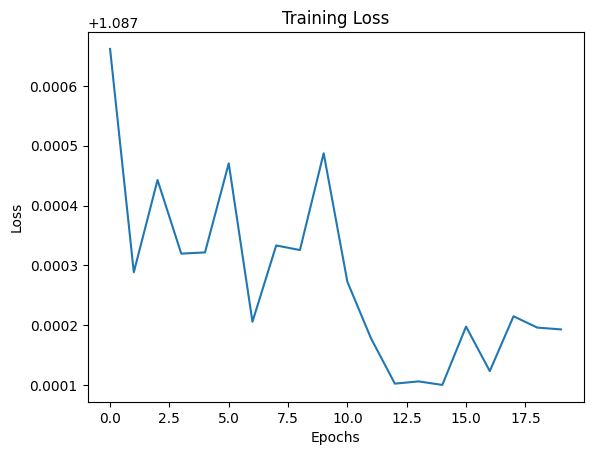

In [ ]:
plt.plot(train_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')

In [ ]:
model.eval()
test_loss = 0.0
correct, total = 0, 0
with torch.no_grad():
    for batch_texts, batch_labels in test_loader:
        batch_texts, batch_labels = batch_texts.to(device), batch_labels.to(device)
        h = model.init_hidden(batch_texts.size(0))
        outputs, h = model(batch_texts, h)
        loss = criterion(outputs, batch_labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum()

print(f"Test Loss: {test_loss / len(test_loader):.4f}")
print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Loss: 1.0414
Test Accuracy: 56.30%


In [ ]:
def predict_sentiment(text, model, vocab, MAX_LEN=50):
    tokens = tokenize_text(text)
    encoded_tokens = encode_tokens(tokens, vocab)
    padded_tokens = pad_sequences(encoded_tokens, MAX_LEN)
    input_tensor = torch.tensor([padded_tokens], dtype=torch.long).to(device)

    model.eval()
    with torch.no_grad():
        h = model.init_hidden(input_tensor.size(0))
        output, h = model(input_tensor, h)
        _, predicted = torch.max(output.data, 1)

    sentiment_mapping = {0: 'negative', 1: 'neutral', 2: 'positive'}
    return sentiment_mapping[predicted.item()]

In [ ]:
text = "i love this movie"
predicted_sentiment = predict_sentiment(text, model, vocab)
print(f"Predicted Sentiment: {predicted_sentiment}")

Predicted Sentiment: neutral
